In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.functional as F

from options import Options
from models import *
from dataset import *
from utils import *

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [2]:
print(os.listdir('models'))
# Change this
model_folder = f"models/RobertaCombinedModel_finetune/"

['.ipynb_checkpoints', 'BERTCombinedModel_finetune', 'RobertaCombinedModel_finetune']


In [3]:
opt = Options()
opt.load_options(model_folder)

state = torch.load(f"{model_folder}/latest.pth", map_location=torch.device('cpu'))
history = torch.load(f"{model_folder}/history.pth")

Dataset = Datasets[opt.dataset]
model = Models[opt.model](opt).to(device)

test_df = pd.read_csv(f"{opt.data_folder}/test.csv")
test_set = Dataset(test_df, opt)
test_loader = DataLoader(test_set, batch_size=30, shuffle=False)

model.load_state_dict(state['state_dict'],)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

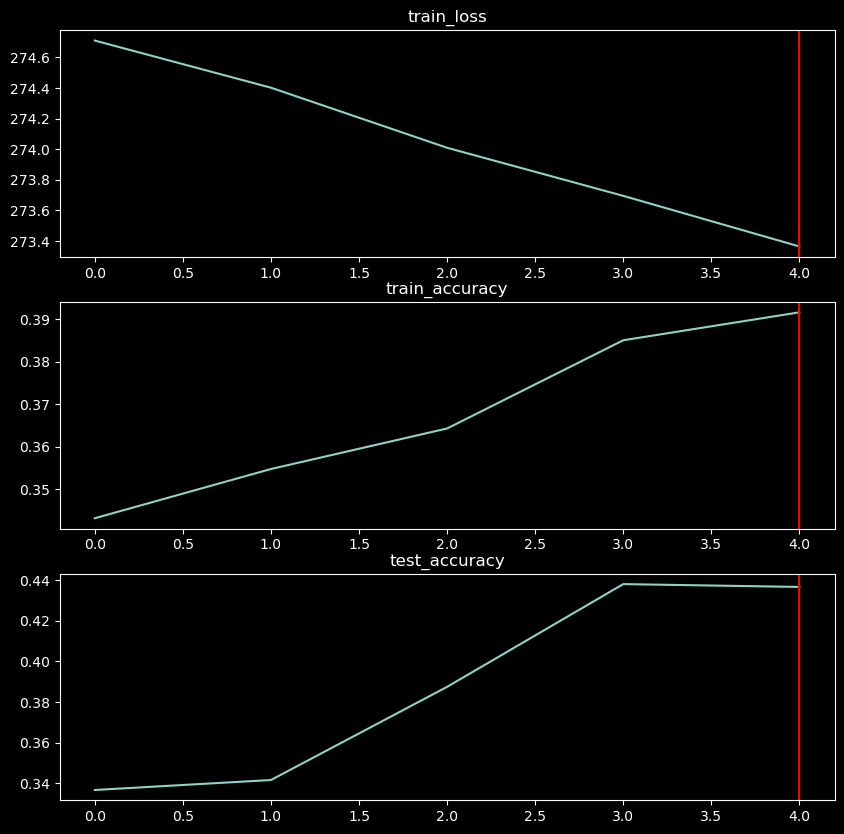

In [4]:
# model = model.to(device)
fig, axs = plt.subplots(len(history),1,figsize=(10,10))
test_best = state['epoch']

for i, key in enumerate(history.keys()):
    ax = axs[i]
    ax.set_title(key)

    ax.plot(history[key])
    ax.axvline(test_best, color='red')

In [5]:
# Confusion matrix and accuracies
y_pred, y_test, test_accuracy = predict(model, test_loader)
print(test_accuracy)

0.4366


In [6]:
y_pred, y_test = torch.tensor(y_pred).detach().numpy(), torch.tensor(y_test).detach().numpy()

In [10]:
# Succ
test_df['y_pred'] = y_pred
test_df['y_test'] = y_test
test_df.loc[y_pred==y_test, ['sentence1', 'sentence2', 'gold_label', 'y_test', 'y_pred']]

,sentence1,sentence2,gold_label,y_test,y_pred
11,"A woman in a blue uniform, with long curly red...",The horse is dead.,contradiction,0,0
12,A small child in a red jacket is sitting on a ...,The child's hands are on the man's head.,entailment,2,2
14,Man with black shirt and sunglasses makes some...,A woman cuts celery.,contradiction,0,0
15,A man in a suit stands on a walkway with is su...,A man is at an airport.,entailment,2,2
16,Man wearing blue bowing on floor in front of a...,A man is wearing something.,entailment,2,2
...,...,...,...,...,...
9993,A woman in a black outfit lies face first on a...,There is a person in a room.,entailment,2,2
9994,A young man is standing near his bike outside ...,The man is old.,contradiction,0,0
9995,Man sitting playing guitar.,A man is sitting and strumming a guitar.,entailment,2,2
9997,This person looks to be snowboarding on a very...,Young snowboarder sizing up their next jump,entailment,2,2


In [12]:
# Fails
test_df.loc[y_pred!=y_test, ['sentence1', 'sentence2', 'gold_label', 'y_test', 'y_pred']]

,sentence1,sentence2,gold_label,y_test,y_pred
0,A kid bored in a train with brown hair and his...,A child is riding the train from New York to B...,neutral,1,2
1,A brown dog and black and white dog run along ...,Two squirrels run after acorns in the grass.,contradiction,0,2
2,A person in full astronaut suit and gear train...,A female astronaut adjusting to the feeling of...,neutral,1,2
3,An old Indian man dressed in rags sleeps on th...,An old Indian man is dressed up,contradiction,0,2
4,A bunch of people are standing all together in...,A group of people are planning something.,neutral,1,2
...,...,...,...,...,...
9984,"A man, boy and a white dog are looking at a di...",A man is all alone looking at postcards.,contradiction,0,2
9986,A crowd of people is looking at something outs...,People are looking inside,contradiction,0,2
9991,A boy spinning on a blue and yellow merry-go-r...,The boy is wearing black.,neutral,1,0
9996,Two women stand in the street both wearing mat...,Two women are dancing in the street wearing dr...,neutral,1,2


              precision    recall  f1-score   support

           0       0.57      0.37      0.45      3413
           1       0.00      0.00      0.00      3219
           2       0.40      0.93      0.56      3368

    accuracy                           0.44     10000
   macro avg       0.32      0.43      0.33     10000
weighted avg       0.33      0.44      0.34     10000



/opt/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


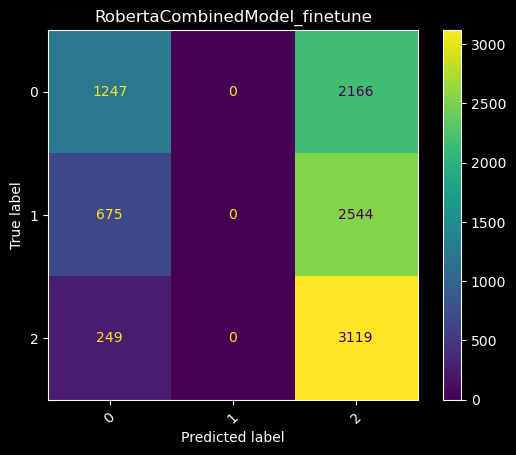

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation = 45)
plt.title(f"{model_folder.split('/')[1]}")
print(classification_report(y_test, y_pred))